In [1]:
from imutils.video import VideoStream
from imutils import face_utils
import datetime
import argparse
import imutils
import time
import dlib
import cv2
import glob
import sys
import os
import shutil 
import math
import numpy as np
from albumentations.augmentations import transforms
import skimage
from tqdm import tqdm

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from scipy import stats as s
import scipy.misc
from PIL import Image


'''import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import Dense, InputLayer, Dropout, Flatten, Activation, GRU, Input, Conv3D, MaxPooling3D, GlobalMaxPooling3D, ZeroPadding3D, AveragePooling3D
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Convolution2D, ZeroPadding2D, Bidirectional, TimeDistributed, GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from keras.preprocessing import image, sequence
from keras.callbacks import ModelCheckpoint'''


#from keras.preprocessing.image import ImageDataGenerator
#from keras.regularizers import l2
#from keras import optimizers

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#make train people ['F01', 'F02', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'M01', 'M02', 'M04']

from utils import mouth_extractor, get_distribution, frames_padding, data_augmenter
train_people, val_people, test_people, classes_num, classes_dict, word_ids = mouth_extractor.split_speakers()

In [3]:
mouth_extractor.create_dirs()

#mouth_extractor.extract_train(2, 2, 2)
#mouth_extractor.extract_val(2, 2, 2)

mouth_extractor.extract_train()
mouth_extractor.extract_val()

100%|██████████| 10/10 [01:15<00:00,  7.57s/it]


In [4]:
all_images, \
video_names, \
frame_nums, \
video_names_uniq, \
frame_nums_uniq, \
vids_and_frames, \
frames_distribution = get_distribution.get_frames_distribution_train()

all_images_val, \
video_names_val, \
frame_nums_val, \
video_names_uniq_val, \
frame_nums_uniq_val, \
vids_and_frames_val, \
frames_distribution_val = get_distribution.get_frames_distribution_val()

In [5]:
print('Train max:', int(max(vids_and_frames.values())))
print('Train min:', int(min(vids_and_frames.values())))
print('Train mean:', (np.array(list(vids_and_frames.values())).astype(np.float).mean()))

print()

print('Val max:', int(max(vids_and_frames_val.values())))
print('Val min:', int(min(vids_and_frames_val.values())))
print('Val mean:', (np.array(list(vids_and_frames_val.values())).astype(np.float).mean()))

Train max: 22
Train min: 5
Train mean: 10.952

Val max: 13
Val min: 5
Val mean: 8.73


/home/dmitrii/Documents/SpeechRecognition/lip_reading/utils/get_distribution.py:110: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


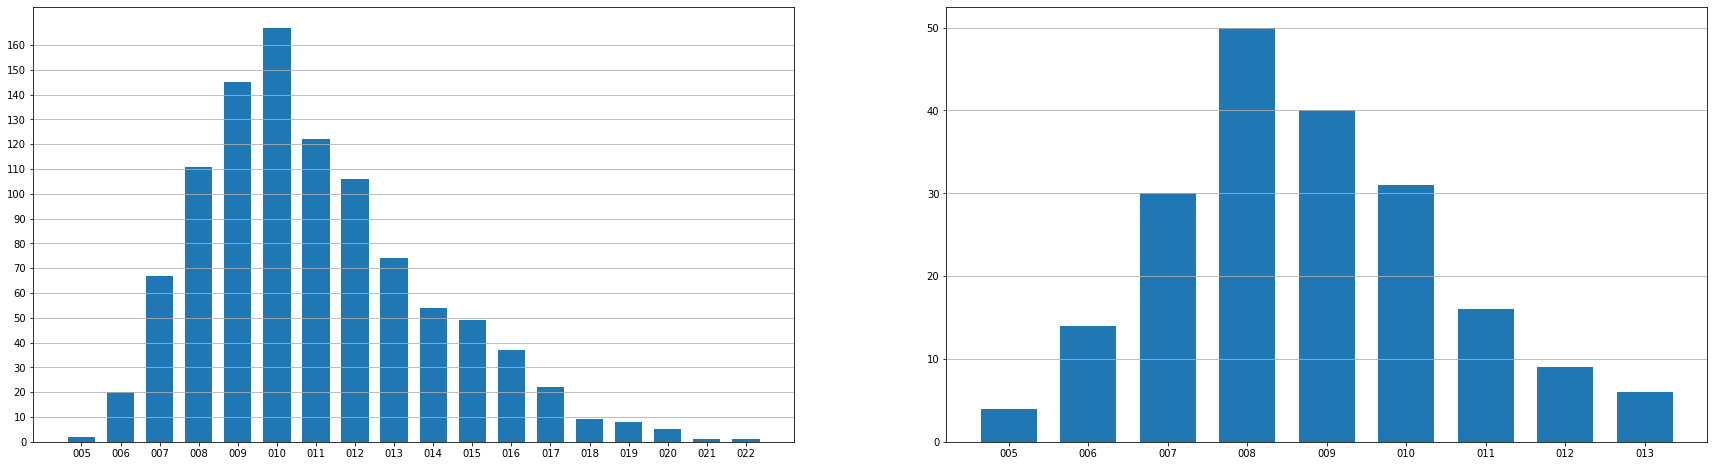

In [6]:
get_distribution.plot_distribution(frames_distribution, frames_distribution_val, 10)

In [7]:
comp, abnormal_vids = frames_padding.remove_short_long_train(all_images, video_names, frame_nums, video_names_uniq, frame_nums_uniq, vids_and_frames, frames_distribution)

Begin Removed 510 ( 510 in this dir)
Choose Removed 810 ( 300 in this dir)
Connection Removed 1406 ( 596 in this dir)
Navigation Removed 2237 ( 831 in this dir)
Next Removed 2593 ( 356 in this dir)
Previous Removed 3031 ( 438 in this dir)
Start Removed 3260 ( 229 in this dir)
Stop Removed 3615 ( 355 in this dir)
Hello Removed 4223 ( 608 in this dir)
Web Removed 4475 ( 252 in this dir)

Removed 349 videos


In [8]:
comp_val, abnormal_vids_val = frames_padding.remove_short_long_val(all_images_val, video_names_val, frame_nums_val, video_names_uniq_val, frame_nums_uniq_val, vids_and_frames_val, frames_distribution_val)

Begin Removed 35 ( 35 in this dir)
Choose Removed 47 ( 12 in this dir)
Connection Removed 169 ( 122 in this dir)
Navigation Removed 320 ( 151 in this dir)
Next Removed 349 ( 29 in this dir)
Previous Removed 404 ( 55 in this dir)
Start Removed 404 ( 0 in this dir)
Stop Removed 410 ( 6 in this dir)
Hello Removed 427 ( 17 in this dir)
Web Removed 466 ( 39 in this dir)

Removed 49 videos


In [9]:
all_images, \
video_names, \
frame_nums, \
video_names_uniq, \
frame_nums_uniq, \
vids_and_frames, \
frames_distribution = get_distribution.get_frames_distribution_train()

all_images_val, \
video_names_val, \
frame_nums_val, \
video_names_uniq_val, \
frame_nums_uniq_val, \
vids_and_frames_val, \
frames_distribution_val = get_distribution.get_frames_distribution_val()

In [10]:
print('Train max:', int(max(vids_and_frames.values())))
print('Train min:', int(min(vids_and_frames.values())))
print('Train mean:', (np.array(list(vids_and_frames.values())).astype(np.float).mean()))

print()

print('Val max:', int(max(vids_and_frames_val.values())))
print('Val min:', int(min(vids_and_frames_val.values())))
print('Val mean:', (np.array(list(vids_and_frames_val.values())).astype(np.float).mean()))

Train max: 12
Train min: 8
Train mean: 9.949308755760368

Val max: 10
Val min: 7
Val mean: 8.47682119205298


In [11]:
len(all_images)

6477

In [12]:
target_frame_num = int(max(vids_and_frames.values())) #12

In [13]:
frames_padding.pad_train(target_frame_num, classes_dict, vids_and_frames)

In [14]:
all_images_padded = []

for classi in classes_dict.values():
    for i in sorted(glob.glob('data/train/' + classi + '/*.jpg')):
        all_images_padded.append(i)
    print(len(all_images_padded))

696
1608
2280
2844
3588
4440
5424
6276
6936
7812


In [15]:
target_frame_num_val = int(max(vids_and_frames_val.values())) #10

In [16]:
frames_padding.pad_val(target_frame_num_val, classes_dict, vids_and_frames_val)

In [17]:
all_images_padded_val = []

for classi in classes_dict.values():
    for i in sorted(glob.glob('data/validation/' + classi + '/*.jpg')):
        all_images_padded_val.append(i)
    print(len(all_images_padded_val))

150
340
440
510
660
810
1010
1200
1380
1510


In [18]:
classes = 'Begin, Choose, Connection, Navigation, Next, Previous, Start, Stop, Hello, Web'
classes = classes.split(', ')

In [19]:
data_augmenter.augment_frames(classes)

Begin dir: removed 0 files. 696 to be augmented
Horizontally flipped 696 files. 1392 in the directory
Vertically flipped 696 files. 2088 in the directory
Noised 2088 files. 4176 in the directory

Choose dir: removed 0 files. 912 to be augmented
Horizontally flipped 912 files. 1824 in the directory
Vertically flipped 912 files. 2736 in the directory
Noised 2736 files. 5472 in the directory

Connection dir: removed 0 files. 672 to be augmented
Horizontally flipped 672 files. 1344 in the directory
Vertically flipped 672 files. 2016 in the directory
Noised 2016 files. 4032 in the directory

Navigation dir: removed 0 files. 564 to be augmented
Horizontally flipped 564 files. 1128 in the directory
Vertically flipped 564 files. 1692 in the directory
Noised 1692 files. 3384 in the directory

Next dir: removed 0 files. 744 to be augmented
Horizontally flipped 744 files. 1488 in the directory
Vertically flipped 744 files. 2232 in the directory
Noised 2232 files. 4464 in the directory

Previous d

In [35]:
import tensorflow as tf

In [39]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [42]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [43]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import Dense, InputLayer, Dropout, Flatten, Activation, GRU, Input, Conv3D, MaxPooling3D, GlobalMaxPooling3D, ZeroPadding3D, AveragePooling3D
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Convolution2D, ZeroPadding2D, Bidirectional, TimeDistributed, GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from keras.preprocessing import image, sequence
from keras.callbacks import ModelCheckpoint

In [44]:
!wget https://gist.githubusercontent.com/Emadeldeen-24/736c33ac2af0c00cc48810ad62e1f54a/raw/f2428c9ba7c13e08e2aa9b2d5ff64ad575a99dd8/tweaked_ImageGenerator_v2.py

--2020-02-11 20:50:08--  https://gist.githubusercontent.com/Emadeldeen-24/736c33ac2af0c00cc48810ad62e1f54a/raw/f2428c9ba7c13e08e2aa9b2d5ff64ad575a99dd8/tweaked_ImageGenerator_v2.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.76.133
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45797 (45K) [text/plain]
Saving to: ‘tweaked_ImageGenerator_v2.py.2’

tweaked_ImageGenera 100%[===================>]  44.72K   108KB/s    in 0.4s    

2020-02-11 20:50:10 (108 KB/s) - ‘tweaked_ImageGenerator_v2.py.2’ saved [45797/45797]



In [45]:
from tweaked_ImageGenerator_v2 import ImageDataGenerator

In [46]:
from keras import optimizers

In [47]:
datagen = ImageDataGenerator()
train_data = datagen.flow_from_directory('data/train', target_size=(50, 100), batch_size=2, frames_per_step=22, shuffle=False)

Found 46872 images belonging to 10 classes.


In [48]:
val_data = datagen.flow_from_directory('data/validation', target_size=(50, 100), batch_size=2, frames_per_step=22, shuffle=False)

Found 1510 images belonging to 10 classes.


In [49]:
import math

print(math.ceil(51120/(2*22)))
print(math.ceil((1510/(2*22))))

1162
35


In [51]:
model_small = Sequential()

model_small.add(ZeroPadding3D(padding=(1, 2, 2), input_shape=(22, 50, 100, 3)))
model_small.add(Conv3D(32, (3, 5, 5), strides=(1, 2, 2), activation='relu'))
model_small.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
model_small.add(Dropout(.3))

model_small.add(ZeroPadding3D(padding=(1, 2, 2)))
model_small.add(Conv3D(64, (3, 5, 5), strides=(1, 1, 1), activation='relu'))
model_small.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
model_small.add(Dropout(.3))

model_small.add(ZeroPadding3D(padding=(1, 1, 1)))
model_small.add(Conv3D(96, (3, 3, 3), strides=(1, 2, 2), activation='relu'))
model_small.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2)))
model_small.add(Dropout(.3))

model_small.add(TimeDistributed(Flatten()))

#model_small.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True)))
model_small.add(Bidirectional(LSTM(256, activation='relu', return_sequences=False)))

model_small.add(Dense(10, activation='softmax'))

RuntimeError: Attempting to capture an EagerTensor without building a function.

In [29]:
from keras.callbacks import ModelCheckpoint
adam2 = optimizers.Adam(lr=0.0001)
save_weights = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model_small.compile(loss='categorical_crossentropy',optimizer=adam2,metrics=['accuracy'])
model_small.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding3d_1 (ZeroPaddin (None, 24, 54, 104, 3)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 22, 25, 50, 32)    7232      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 22, 12, 25, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 12, 25, 32)    0         
_________________________________________________________________
zero_padding3d_2 (ZeroPaddin (None, 24, 16, 29, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 22, 12, 25, 64)    153664    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 22, 6, 12, 64)    

In [30]:
history = model_small.fit_generator(train_data, epochs=20, steps_per_epoch=1162, 
                              validation_data=val_data, validation_steps=35, shuffle=False)

Epoch 1/20
   4/1162 [..............................] - ETA: 5:09:17 - loss: 6.7499 - accuracy: 0.9716

KeyboardInterrupt: 

In [52]:
from keras.models import Model

In [53]:
video = Input(shape=(22, 50, 100, 3))

cnn_base = MobileNetV2(input_shape=(50, 100, 3), include_top=False)
cnn_out = GlobalAveragePooling2D()(cnn_base.output)

cnn = Model(input=cnn_base.input, output=cnn_out)
encoded_frames = TimeDistributed(cnn)(video)

encoded_sequence = GRU(66)(encoded_frames)
outputs = Dense(10, activation="softmax")(encoded_sequence)

model = Model([video], outputs)

/home/dmitrii/pythonenvs/lr13.6/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 4s 0us/step


/home/dmitrii/pythonenvs/lr13.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`
  


In [ ]:
adam2 = optimizers.Adam(lr=0.0001)
save_weights = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model.compile(loss='categorical_crossentropy',optimizer=adam2,metrics=['accuracy'])
model.summary()